# Time-Series Forecasting using Machine Learning

This notebook is used to perform preliminary data analysis and forecasting of a power-load time-series. The aim of the present notebook is to provide a report on main features of a power-load series, that runs from 2006 to 2019. Then, one dives into the time-series forecasting, with a horizon of one year ahead.

## Libraries

The libraries used in this notebook are:

In [7]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pio.renderers.default = 'notebook' 
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
import shap
shap.initjs()

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

## Step 1: data analysis

The first step is to analyse the dataset. This is [load.csv](/datasets/load.csv), containing a time-series of the power load (Wh) of an Italian building, covering a timespan from 2006-01-01 to 2022-02-07. The set only contains 2 columns and 5112 records, encoding the date of the record and the power load (Wh).

In [8]:
# Loading the data
# ==============================================================================
data = pd.read_csv('datasets/load.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5113 entries, 0 to 5112
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5113 non-null   object 
 1   Load    5113 non-null   float64
dtypes: float64(1), object(1)
memory usage: 80.0+ KB


Now one manipulates the data, converting the `Date` column to `datetime` format, and setting it as index. The frequeuency `1D` is specified as the data have been taken every 1 day. 

In [9]:
# Data preparation
# ==============================================================================
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data = data.set_index('Date')
data = data.asfreq('1D')
data = data.sort_index()
data.head(5) 

,Load
Date,
2006-01-01,666542.0
2006-01-02,855403.0
2006-01-03,914705.0
2006-01-04,926705.0
2006-01-05,927560.0


Missing data are checked with frequency of 1 day, and if any, a not-a-number (`nan`) value is used for filling them. In this case, the time series is complete.

In [34]:
# Verify that the time series is complete
# ==============================================================================
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

print(f"Number of rows with missing values: {data.isnull().any(axis=1).mean()}")

# if not complete, fill with NaN values
if data.isnull().any(axis=1).mean() > 0.0:
    data.asfreq(freq='1D', fill_value=np.nan)

Number of rows with missing values: 0.0


Since the ultimate aim is to provide a time-series forecasting, the data is divided into 2 sets: training and test. The testing of the forecasting model is performed with 2019 as a reference.

In [35]:

# Split the remaining data into train-validation-test
# ==============================================================================
data = data.loc['2006-01-01': '2019-12-31'].copy()
start_train = '2006-01-01'
end_train = '2018-12-31'
start_test = '2019-01-01'
data_train = data.loc[start_train:end_train, :].copy()
data_test  = data.loc[start_test:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2006-01-01 00:00:00 --- 2018-12-31 00:00:00  (n=4748)
Test dates       : 2019-01-01 00:00:00 --- 2019-12-31 00:00:00  (n=365)


### Plot time series

In this section, graphical exploration is provided of the dataset. This allows to identify trends and patterns. The section first provides plots the full time series, providing some zoom on interesting areas, and then presents some seasonality plots.

To plot the time series, a `go.Figure()` object is created using the Plotly libray, that provides interactive plots by default. Train and test data are also represented in successive figure.

In [36]:
# Interactive plot of time series
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Load'], mode='lines', name='Load'))
fig.update_layout(
    title  = 'Power load (Wh)',
    xaxis_title="Time",
    yaxis_title="Load",
    legend_title="Partition:",
    width=850,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

An highlight of the train and test sets is also provided.

In [37]:
# Interactive plot of time series
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['Load'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['Load'], mode='lines', name='Test'))
fig.update_layout(
    title  = 'Power load (Wh)',
    xaxis_title="Time",
    yaxis_title="Load",
    legend_title="Partition:",
    width=850,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

From the graph one notices that the power load has annual seasonality. In particular, highest peaks occurr almost every July, while lowest peaks are shifted approximately 4 months one after the other (e.g., December/January to April, April to August, August to December/January). This is also shown in the following figure, zooming on a reference year (2018 in this case).

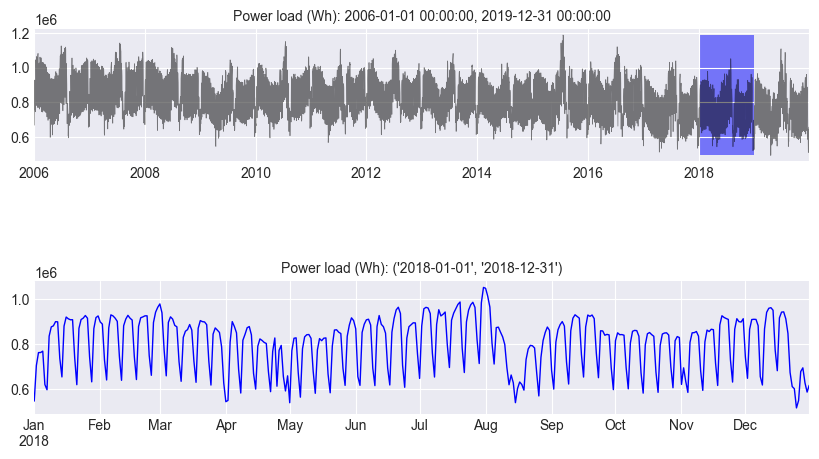

In [38]:
# Zooming time series chart
# ==============================================================================
zoom = ('2018-01-01','2018-12-31')

fig = plt.figure(figsize=(10, 5))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[:3, :])
data.Load.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(data.Load)
max_y = max(data.Load)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_title(f'Power load (Wh): {data.index.min()}, {data.index.max()}', fontsize=10)
main_ax.set_xlabel('')

zoom_ax = fig.add_subplot(grid[5:, :])
data.loc[zoom[0]: zoom[1]].Load.plot(ax=zoom_ax, color='blue', linewidth=1)
zoom_ax.set_title(f'Power load (Wh): {zoom}', fontsize=10)
zoom_ax.set_xlabel('')

plt.subplots_adjust(hspace=1)
plt.show()

A zoom is also provided on a reference short-term period (i.e., January-February span in 2018, in this case). This shows that the power load is cyclic with respect to the day of the week. In particular, since the 2018-01-01 was Sunday, the power load reaches its minimum roughly every 7 days, i.e., every weekend.

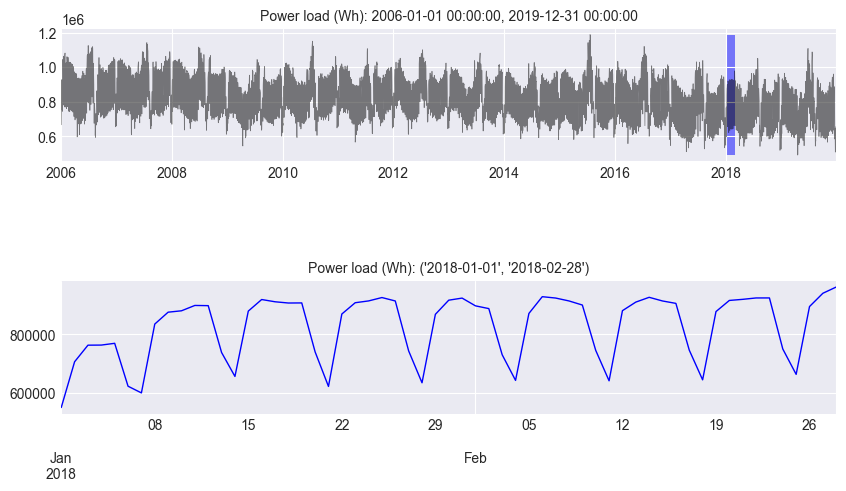

In [39]:
# Zooming time series chart
# ==============================================================================
zoom = ('2018-01-01','2018-02-28')

fig = plt.figure(figsize=(10, 5))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[:3, :])
data.Load.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(data.Load)
max_y = max(data.Load)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_title(f'Power load (Wh): {data.index.min()}, {data.index.max()}', fontsize=10)
main_ax.set_xlabel('')

zoom_ax = fig.add_subplot(grid[5:, :])
data.loc[zoom[0]: zoom[1]].Load.plot(ax=zoom_ax, color='blue', linewidth=1)
zoom_ax.set_title(f'Power load (Wh): {zoom}', fontsize=10)
zoom_ax.set_xlabel('')

plt.subplots_adjust(hspace=1)
plt.show()

### Seasonality plots

Seasonal plots are provided to identify seasonal patterns and trends in the series. This can be obtained with boxplots, that average the data over time.

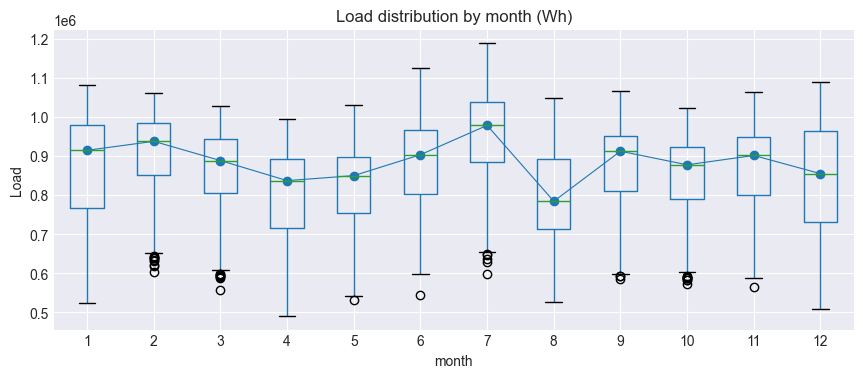

In [40]:
# Load distribution by month
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 4))
data['month'] = data.index.month
data.boxplot(column='Load', by='month', ax=ax,)
data.groupby('month')['Load'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Load')
ax.set_title('Load distribution by month (Wh)')
fig.suptitle('')
plt.show()

It is observed an annual peak in July, with minimum in August, possibly due to the summer-period vacations.

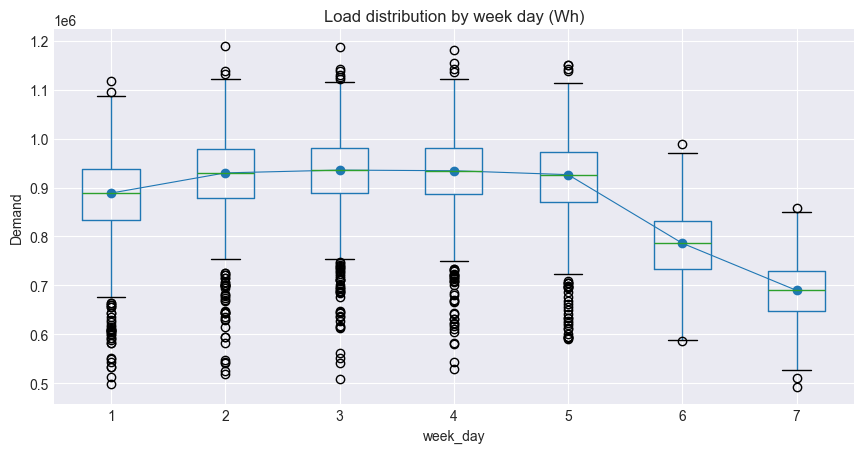

In [41]:
# Demand distribution by week day
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 5))
data['week_day'] = data.index.day_of_week + 1
data.boxplot(column='Load', by='week_day', ax=ax)
data.groupby('week_day')['Load'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Load distribution by week day (Wh)')
fig.suptitle('')
plt.show()

The load increases in the mid-days of the week, with minimum in the weekends, as already anticipated.

## Step 2: forecasting

The aim of the second step is to develop a long-term forecasting model for the power load with a 1-year horizon.

### Recursive multi-step forecasting

The recursive multi-step forecasting [ForecasterAutoreg](https://joaquinamatrodrigo.github.io/skforecast/0.11.0/user_guides/autoregresive-forecaster.html) is used, with [LGBMRegressor](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html) as regressor. In recursive multi-step forecasting, predicted values from previous time steps are used to forecast the values for the next steps. A window of 1850 days (1850 lags) is used to predict the next day demand (**steps**). Such values are selected rather arbitrarly by trial and error. Maybe an **autocorrelation** analysis might cast some insight on this. The hyperparameters of the regressor are left as default for the moment.

[LGBMRegressor](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html) is a gradient-boosting framework developed by Microsoft, that implements sequential regression trees, where each new tree is trained to correct the errors made by the previous trees.


In [43]:
# Set the forecast horizon and the lags
# ==============================================================================
steps = 1
lags = 1850

# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=15926, verbose=-1),
                 lags      = lags
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_train, 'Load'])
forecaster


ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=15926, verbose=-1) 
Lags: [   1    2    3 ... 1848 1849 1850] 
Transformer for y: None 
Transformer for exog: None 
Window size: 1850 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2006-01-01 00:00:00'), Timestamp('2018-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-04-16 15:1

A backtesting is performed, that consists in generating a forecast for each observation in the test set. Then the predicted value is compared with the actual one. The mean absolute error (MAE) is used as performance metric. The lower the MAE, the smaller the prediction errors on average. More information are given in the Results section. 

In [45]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Load'],
                          steps              = steps,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data.loc[:end_train]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = True,
                          show_progress      = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 4748
Number of observations used for backtesting: 365
    Number of folds: 365
    Number of steps per fold: 1
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2006-01-01 00:00:00 -- 2018-12-31 00:00:00  (n=4748)
    Validation: 2019-01-01 00:00:00 -- 2019-01-01 00:00:00  (n=1)
Fold: 1
    Training:   2006-01-01 00:00:00 -- 2018-12-31 00:00:00  (n=4748)
    Validation: 2019-01-02 00:00:00 -- 2019-01-02 00:00:00  (n=1)
Fold: 2
    Training:   2006-01-01 00:00:00 -- 2018-12-31 00:00:00  (n=4748)
    Validation: 2019-01-03 00:00:00 -- 2019-01-03 00:00:00  (n=1)
Fold: 3
    Training:   2006-01-01 00:00:00 -- 2018-12-31 00:00:00  (n=4748)
    Validation: 2019-01-04 00:00:00 -- 2019-01-04 00:00:00  (n=1)
Fold: 4
    Training:   2006-01-01 00:00:00 -- 2018-12-31 00:00:00  (n=4748)
    Validation: 2019-01-05 00:00:00 

  0%|          | 0/365 [00:00<?, ?it/s]

The MAE is then printed.

In [46]:
# Backtesting error
# ==============================================================================
print(f'Backtest error (MAE): {metric}')

Backtest error (MAE): 22473.214169529892


One can then plot the predicted values and the actual ones to appreciate the validity of the forecasting.

In [47]:
# Plot predictions vs real value
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['Load'], name="to predict", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Real value vs predicted in test data (Wh)",
    xaxis_title="Date time",
    yaxis_title="Load",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

Last step in the forecasting is the hyperparameter tuning. A [Bayesian Search](https://skforecast.org/0.11.0/user_guides/hyperparameter-tuning-and-lags-selection.html#bayesian-search) is performed to find the best setup for the model. Compared to Grid Search and Random Search, Bayesian Search uses information on hyperparameters of previous computed performances to guide the search towards most promising regions. A `bayesian_search_forecaster()` function is used, while the search space bounds are specified in the function `search_space()`.

In [52]:
# Hyperparameters search
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=15926, verbose=-1),
                 lags      = lags, # This value will be replaced in the search
             )

# Lags used as predictors
lags_grid = [lags, [1000, 1500, 1850, 1900, 2000, 2500, 2800, 2900, 3000]]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 800, 1500, step=100), # number of decision trees
        'max_depth'     : trial.suggest_int('max_depth', 3, 10, step=1),          # max. depth of each  tree
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),        # step size towards the minimum of the loss function
        'reg_alpha'     : trial.suggest_float('reg_alpha', 0, 1, step=0.1),       # L1 regularization
        'reg_lambda'    : trial.suggest_float('reg_lambda', 0, 1, step=0.1),      # L2 regularization
    } 
    return search_space

The search is then performed (be careful, as it may take some time depending on the machine).

In [53]:
# Perform the search
# ==============================================================================
results_search, frozen_trial = bayesian_search_forecaster(
                                   forecaster         = forecaster,
                                   y                  = data.loc[:, 'Load'],
                                   steps              = steps,
                                   metric             = 'mean_absolute_error',
                                   search_space       = search_space,
                                   lags_grid          = lags_grid,
                                   initial_train_size = len(data[:end_train]),
                                   refit              = False, 
                                   n_trials           = 100,    # Increase for more exhaustive search
                                   random_state       = 123,    # To reproduce results
                                   return_best        = True,   # To return best forecast parameters
                                   n_jobs             = 'auto', # '-1' to use all available cores
                                   verbose            = False,
                                   show_progress      = True
                               )

# Search results
# ==============================================================================
results_search.head(10)

Number of models compared: 200,
         100 bayesian search in each lag configuration.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [   1    2    3 ... 1848 1849 1850] 
  Parameters: {'n_estimators': 1200, 'max_depth': 5, 'learning_rate': 0.0100786818966835, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
  Backtesting metric: 21579.712314528235



,lags,params,mean_absolute_error,n_estimators,max_depth,learning_rate,reg_alpha,reg_lambda
97,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1200, 'max_depth': 5, 'learni...",21579.712315,1200.0,5.0,0.010079,0.1,0.1
53,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1500, 'max_depth': 5, 'learni...",21601.195430,1500.0,5.0,0.010491,0.1,0.0
83,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1300, 'max_depth': 5, 'learni...",21619.435397,1300.0,5.0,0.010407,0.1,0.1
54,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 800, 'max_depth': 5, 'learnin...",21704.180692,800.0,5.0,0.012273,0.1,0.0
52,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1400, 'max_depth': 5, 'learni...",21749.184954,1400.0,5.0,0.014411,0.1,0.0
82,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1300, 'max_depth': 5, 'learni...",21760.170304,1300.0,5.0,0.011119,0.0,0.1
75,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1000, 'max_depth': 5, 'learni...",21761.844768,1000.0,5.0,0.023305,0.0,0.2
86,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1300, 'max_depth': 5, 'learni...",21770.772120,1300.0,5.0,0.012684,0.0,0.2
98,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1200, 'max_depth': 5, 'learni...",21798.823567,1200.0,5.0,0.010171,0.2,0.1
81,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1300, 'max_depth': 5, 'learni...",21804.038492,1300.0,5.0,0.010262,0.0,0.1


The best setup is returned and the final model is backtested on the data.

In [57]:
# Backtest final model on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data.loc[:,'Load'],
                          steps              = steps,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data[:end_train]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False, # Change to True to see detailed information
                          show_progress      = True
                      )

print(f"Backtest error (MAE): {metric:.2f}")

  0%|          | 0/365 [00:00<?, ?it/s]

Backtest error (MAE): 21579.71


As it can be seen, tuning the hyperparameters has returned a lower MAE, i.e., 21579.71 Wh compared to previous 22473.21 Wh. The new plot of the predictions is provided.

In [54]:
# Plot predictions vs real value
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['Load'], name="to predict", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Real value vs predicted in test data (Wh)",
    xaxis_title="Date time",
    yaxis_title="Load",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)

## Results, limitations and future work

The MAE has been used as perfomance metric in this study. This is computed as follows:

$ MAE = \frac{\sum_{i=1}^{N}|y_i - \hat{y}_i|}{N} $ 

where $ N $ is the number of test data, $ y_i $ and $ \hat{y}_i $ are the true and predicted values. The MAE provides a measure of the average magnitude of errors between your predictions and the actual values. A lower MAE indicates smaller errors on average, suggesting that the predictions are closer to the actual values. The MAE is expressed in the same units as the original data, making it interpretable.

In the current case, a MAE of 21579.71 Wh migth be considered acceptable or not depending on the specific application of the current analysis. Such error is at least one order of magnitude lower than the minimum power load in the datasets, i.e., approximately 500k Wh, occurring in April 2019. The percentage error is thus around 4%. From the previous plot, one sees that the minimum and maximum values are not well approximated by the predictions in April and June, respectively. This is seen also in the next figure, showing the magnitude of the residuals with respect to time.

Text(0.5, 1.0, 'Residuals (Wh)')

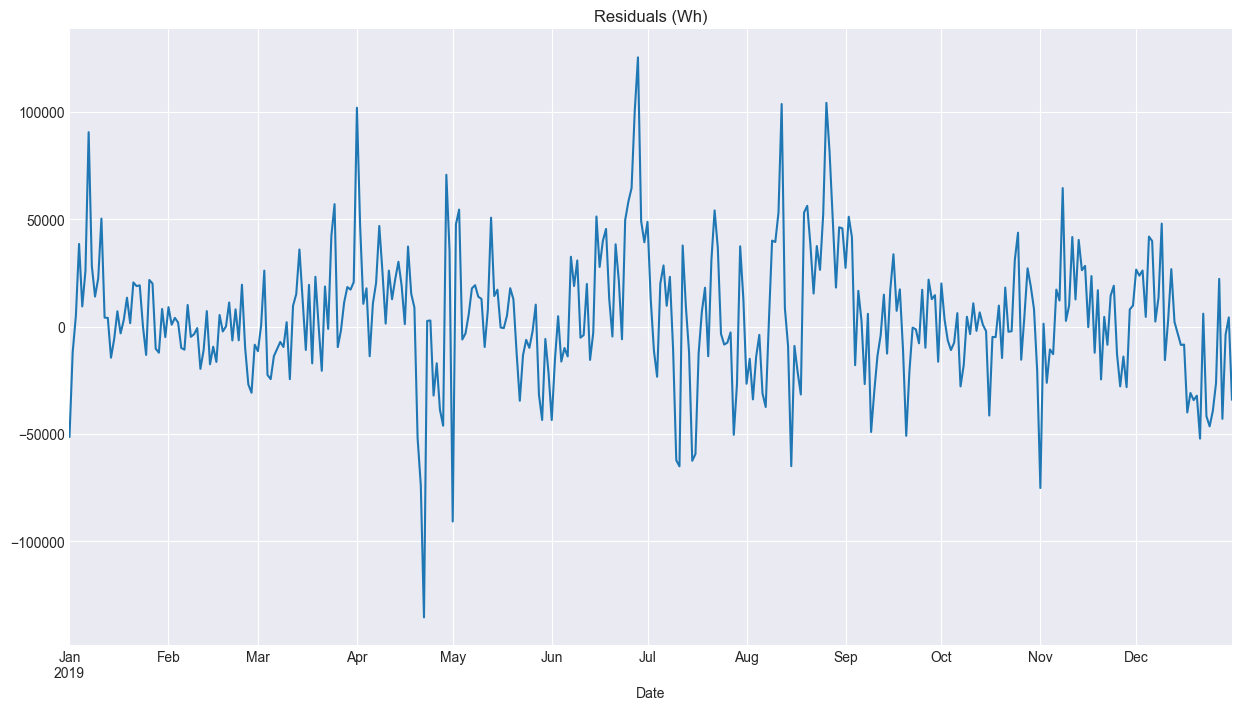

In [55]:
# Compute the residuals
# ==============================================================================
actual_values = data.loc[start_test:, 'Load']
predicted_values = predictions['pred']
residuals = actual_values - predicted_values


# plot the residuals
fig, ax = plt.subplots(figsize=(15, 8))
residuals.plot(ax=ax, label='Load')
ax.set_title('Residuals (Wh)')


The reson behind this might lie in the magnitude of such minimum and maximum values at April and June, respectively. In particular, the minimum power load in April 2019 is also the global minimum in the whole dataset, thus it might be difficult for the model to predict that value. Similarly, only 4 peaks in June throughout the whole dataset (more than 10 years!) reached similar values to that of June 2019. 

The use of lags and their relations with the performance metric need deeper understanding, maybe testing few more values in the Bayesian search. Finally, more models can be tested to identify the one that is more suited for the application. In addition, adding exogenous variables (e.g., the air temperature and/or humidity) might improve the model.